# **Identificación de Imágenes Auténticas y Sintéticas : Abordando los Desafíos de las Imágenes Sintéticas en la Sociedad Actual**

**Contenido**
1. [Configuración del Entorno](#title1)
2. [Construcción del Conjunto de Datos](#title2)
3. [Creación del Modelo](#title3)

## Configuración del Entorno<a name="title1"></a>

In [1]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices("GPU"))
print(tf.__version__)
# Para limitar la memoria que usa la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para que solo utilice la GPU si es necesario
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuración de GPU completada")
    except RuntimeError as e:
        print(e)
# Verifica que la GPU está disponible
print("¿GPU está disponible?:", tf.config.list_physical_devices('GPU'))
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import gc
import tensorflow as tf
from keras import backend as K

# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
Configuración de GPU completada
¿GPU está disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


0

In [ ]:
# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

In [5]:
#@title Importar todas las librerías de uso.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import glob
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from sklearn import metrics
import matplotlib.image as mpmig
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

sns.set_theme()

## Construcción del Conjunto de Datos y Preprocesandolos<a name="title2"></a>

Fuente: https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset & https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces/code

In [18]:
# Parameters
batch_size = 32
img_height = 128
img_width = 128
epochs = 10

# Cargar imágenes de entrenamiento
train_folder = './Data/Train'
train_images = []
train_labels = []
# Cargar imágenes de testeo
test_folder = './Data/Test'
test_images = []
test_labels = []
# Load datasets
# Cargar datasets
train_dataset = image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Capturar class_names antes de prefetch
class_names = train_dataset.class_names
print("Clases:", class_names)

validation_dataset = image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_dataset = image_dataset_from_directory(
    test_folder,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Prefetching para mejorar el rendimiento
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 9630 files belonging to 2 classes.
Using 7704 files for training.
Clases: ['Fake', 'Real']
Found 9630 files belonging to 2 classes.
Using 1926 files for validation.
Found 1289 files belonging to 2 classes.


# Modelo<a name="title3"></a>



In [20]:
#@title Construcción del modelo
# Construcción del modelo
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),

    # Bloque convolucional 1
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Bloque convolucional 2
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Bloque convolucional 3
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Aplanamiento y capas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Usar class_names capturadas
])
# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 conv2d_46 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 62, 62, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_47 (Conv2D)          (None, 60, 60, 128)      

In [21]:
# Entrenar el modelo
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
241/241 [==============================] - 19s 57ms/step - loss: 0.0239 - accuracy: 0.9918 - val_loss: 0.2351 - val_accuracy: 0.8889
Epoch 2/10
241/241 [==============================] - 12s 50ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.1344 - val_accuracy: 0.9465
Epoch 3/10
241/241 [==============================] - 12s 50ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 1.9275e-04 - val_accuracy: 1.0000
Epoch 4/10
241/241 [==============================] - 12s 50ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.3515 - val_accuracy: 0.8811
Epoch 5/10
241/241 [==============================] - 12s 50ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 8.9910e-04 - val_accuracy: 0.9995
Epoch 6/10
241/241 [==============================] - 12s 50ms/step - loss: 7.1406e-04 - accuracy: 0.9997 - val_loss: 6.9954e-05 - val_accuracy: 1.0000
Epoch 7/10
241/241 [==============================] - 12s 50ms/step - loss: 5.7514e-04 - accuracy: 0.9999 - val_loss: 0.

41/41 [==============================] - 1s 14ms/step - loss: 0.3041 - accuracy: 0.9154
Pérdida en el conjunto de test: 0.30413129925727844
Precisión en el conjunto de test: 0.9154383540153503
41/41 [==============================] - 1s 13ms/step


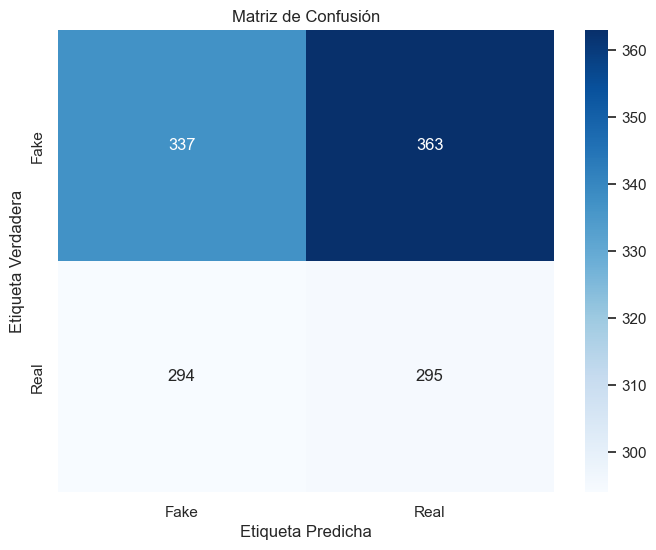


Reporte de Clasificación:
              precision    recall  f1-score   support

        Fake       0.53      0.48      0.51       700
        Real       0.45      0.50      0.47       589

    accuracy                           0.49      1289
   macro avg       0.49      0.49      0.49      1289
weighted avg       0.49      0.49      0.49      1289

Precisión Global: 0.4903025601241272


In [23]:
#@title Metricas

# Evaluación del modelo
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Pérdida en el conjunto de test: {test_loss}")
print(f"Precisión en el conjunto de test: {test_accuracy}")

# Generar Predicciones y Métricas
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Matriz de Confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de Clasificación
print("\nReporte de Clasificación:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Precisión Global
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Precisión Global: {accuracy}")

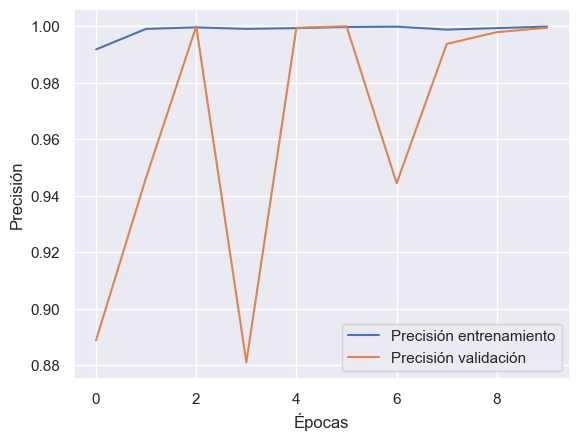

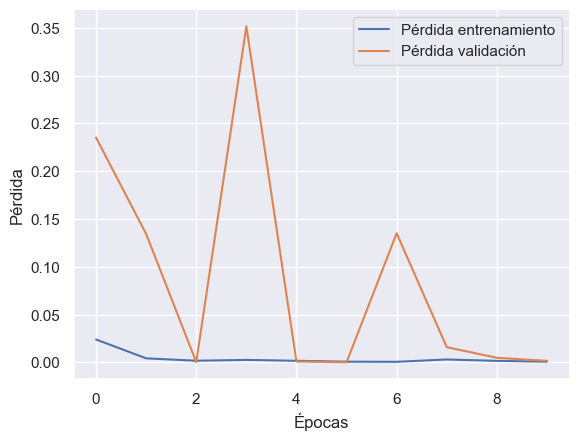

In [24]:
# Visualizar los resultados de entrenamiento
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()